In [1]:
%pylab inline
from ipywidgets import interact

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')

### Load test file

In [3]:
din  = np.fromfile('spkDect_test_spk.bin', dtype='float32')

In [5]:
data = np.zeros((40,8))
k = 0
for t in range(40):
    for ch in range(8):
        data[t,ch] = din[k]
        k+=1

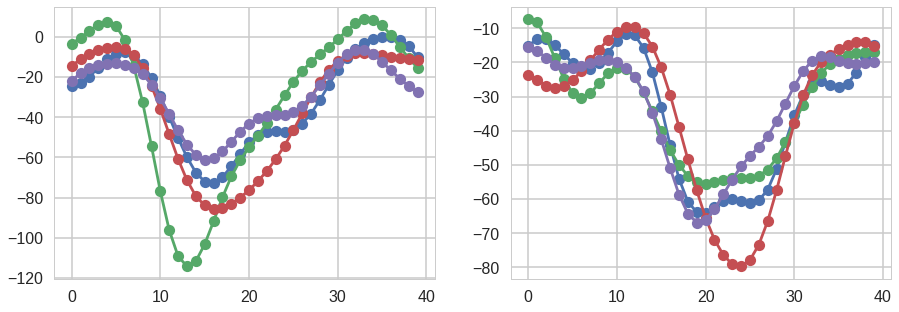

In [33]:
fig,ax = subplots(1,2,figsize=(15,5))
ax[0].plot(data[:,:4], '-o');
ax[1].plot(data[:,4:], '-o');

### Run Vivado Simulation

!vivado_hls /disk0/Work/xike_hls_module/hls_proj/spk_dect/solution1/script.tcl

### State Machine of Each Channel

Each individual channel has a `finite state machine` which operate in **FPGA** while real-time data acquisition and is designed as below:

```
//////////////////////////////////////////////////////////////////////////////////
//
//    s0                               s0
//      s0                    s0    s0    s0
//        s0               s0    s0          s0          s0
//   --------------------------------------------------------- threshold
//          s1          s2                      s1    s2
//                    s2                           s1
//            s1    s2
//                s2
//              s1
//
//////////////////////////////////////////////////////////////////////////////////
```

In [67]:
def show_sim_results(dout, thr):
    y = dout.reshape(40,8)
    fig, ax = subplots(4,2,figsize=(15,20))
    color = ['g','c']
    for ch in range(8):
        x = data[:,ch]          
        idx = argmin(x)
        ax[ch/2, ch%2].plot(x,'-o', c=color[ch/4], alpha=0.5)
        ax[ch/2, ch%2].plot(y[:,ch]/float(2**13),'-o', alpha=0.5);
        ax[ch/2, ch%2].axhline(thr ,c='m', ls='--')
        ax[ch/2, ch%2].axvline(idx ,c='m', ls='-.')

#### 1. This simulation generate the *dout* as states

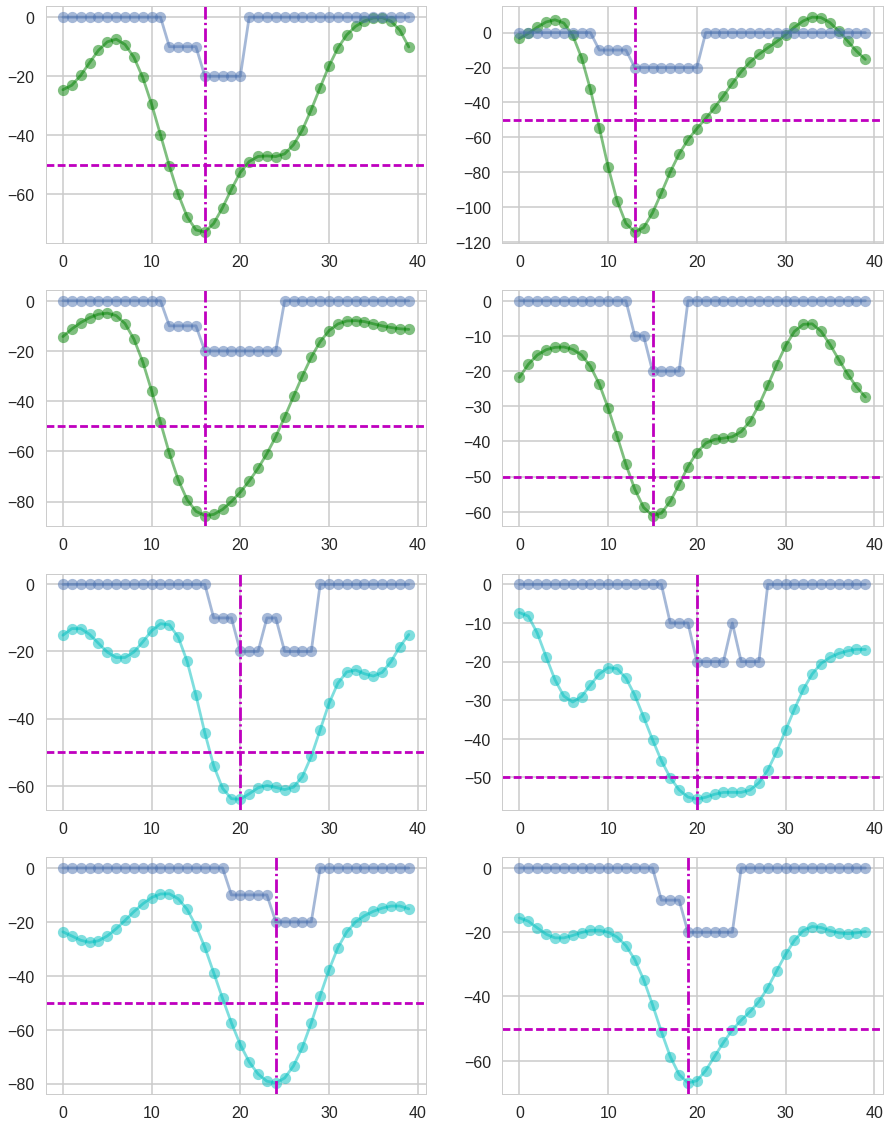

In [73]:
dout  = np.fromfile('spkDect_test_compare.bin', dtype='int32')
thr = -50
show_sim_results(dout, thr)

Now, clearly we extract 8 peaks from 8 independent `state machine`, the upper 4 is from one `tetrode` and the below 4 from another.

The next task is to generate a `pivital position`:(t, ch) tuple from the `state machines` and label it.

#### 2. This simulation generate the *dout* as Min value

Min value is resored in `Mn` and is updated by comparing `thr` to current `val`
```verilog
if(val<thr && val<Mn[ch])        Mn[ch] = val;
else if(val>=thr)                Mn[ch] = 0;
```

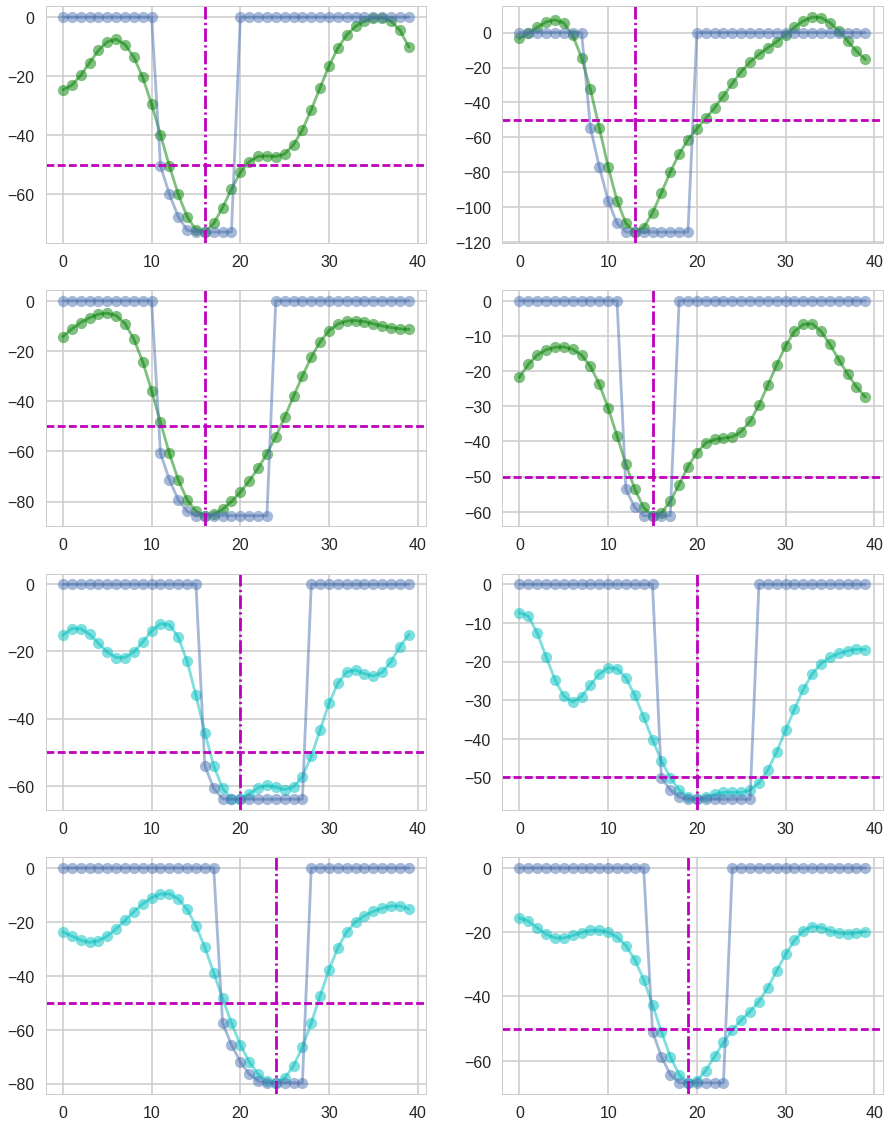

In [72]:
dout  = np.fromfile('spkDect_test_compare.bin', dtype='int32')
thr = -50
show_sim_results(dout, thr)

Notice that all the output is decided by *one time stamps* delay, so that from **FPGA** view point `Mn` is related to the value of the next value `val`. 

#### 3. Simulation of pivotal point

1. `_val` is the current value to be processed by `state machine` which you already know `val` is the following value from current `ch`
2. `_val_nn` is the current value from all channels in the same group
3. `ch_nn[i]` is the channel numbers in this group
4. `Mn` is the minimum value from all channels updated by `val`
5. `start_cnt[ch]==1` means pivotal is already found at that `ch` and no pivotal can be labelled unless `start_cnt[ch]` get reset.  

> inactivating counter (independent for each channel)
```verilog
if(start_cnt[ch])
{
    cnt[ch] += 1;
    if (cnt[ch] == INACTIVE_LEN)
    {
        cnt[ch] = 0;
        start_cnt[ch] = 0;
    }
}
```

> pivotal judgement (accross channel comparison so not independent)
```verilog
bool if_pivotal = 1;
Get_Com_Loop:  // loop hls unroll
for(int i=0; i<CH_PG; i++)
{
    _val = buf_2d[l][ch];
    _val_nn[i] = buf_2d[l][ch_nn[i]];
    if_pivotal = (_val <= Mn[ch_nn[i]]) && 
                 (_val <= _val_nn[i])   && 
                 !start_cnt[ch_nn[i]]   && if_pivotal;
}
```

> `if_pivotal` (not independent for each channel) at **S1** to **S2** (independent)
```verilog
case S1:
if(_val<thr && _val>val){
   state[ch] = S1;
   is_peak[ch] = 0;
   first_S2[ch] = 0;
}
else if(_val<thr && _val<=val){
   state[ch] = S2;
   is_peak[ch] = 0;
   first_S2[ch] = 1;
   if(if_pivotal) 
       {
           _val.range(0,0) = 1;
           is_peak[ch] = 1;
           start_cnt[ch] = 1;
       }
   else
       {
           is_peak[ch] = 0;
       }
}
else if(_val>=thr){
   state[ch] = S0;
   is_peak[ch] = 0;
   first_S2[ch] = 0;
}
break;
```

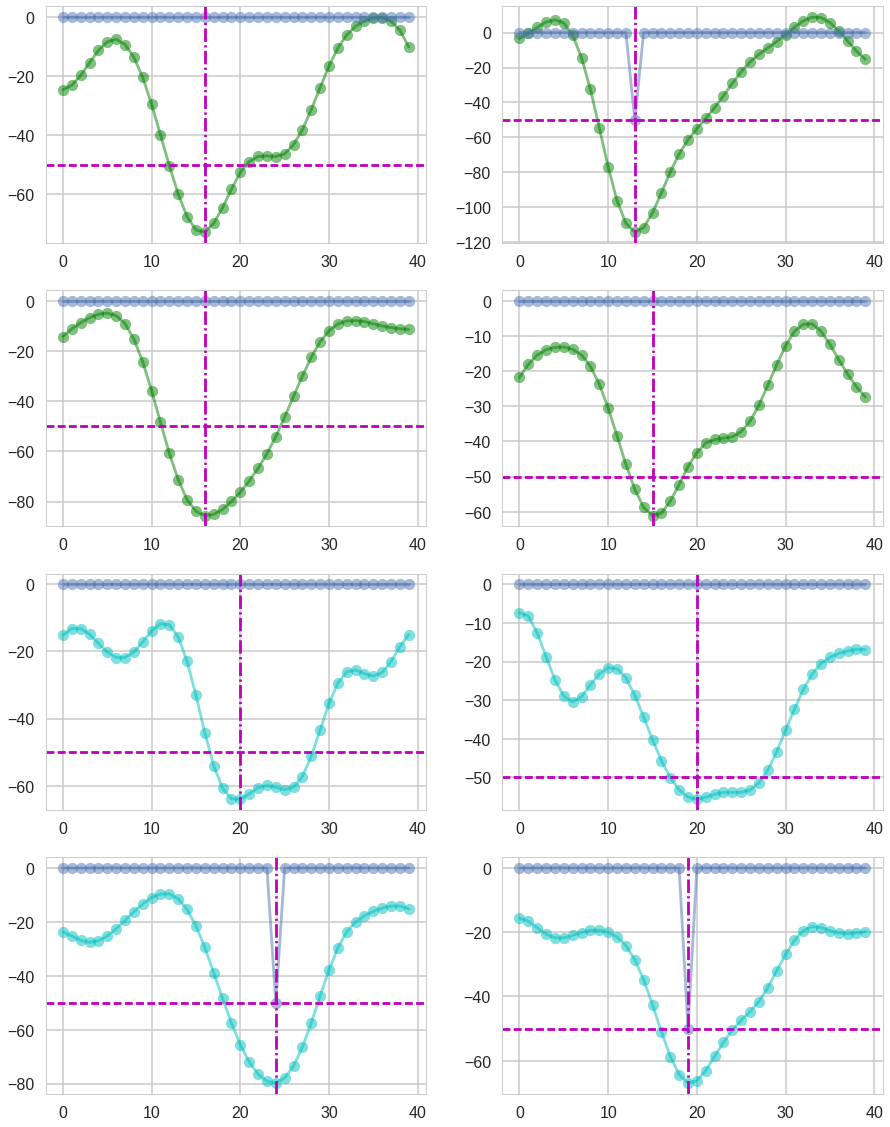

In [80]:
dout  = np.fromfile('spkDect_test_compare.bin', dtype='int32')
thr = -50
show_sim_results(dout, thr)

### Summary

In [132]:
dout  = np.fromfile('spkDect_test_compare.bin', dtype='int32')
thr = -50

```verilog
muap.data = thr*is_peak[ch];
```

In [88]:
y = dout.reshape(40,8)/float(2**13)
piv = np.where(y==thr)

```verilog
muap.data = _val;
```

In [136]:
y = dout.reshape(40,8)
piv = np.where(y%2==1)

In [137]:
piv

(array([13, 19, 24]), array([1, 7, 6]))

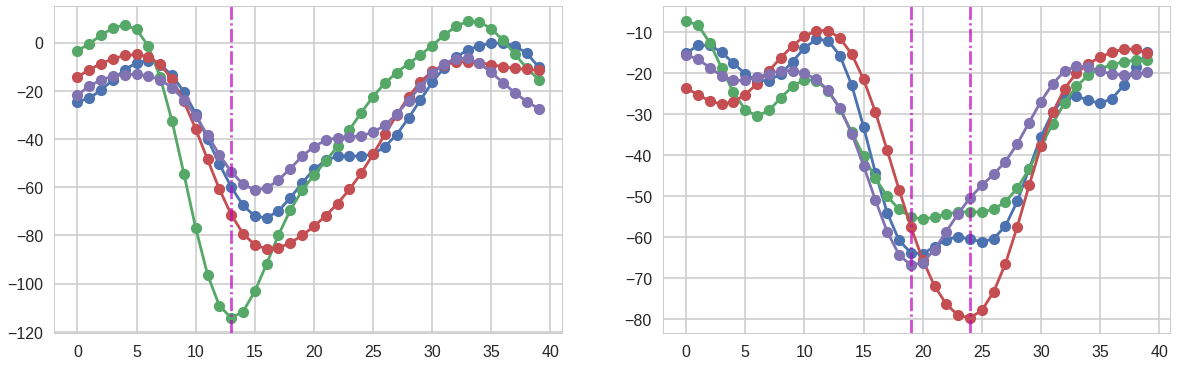

In [138]:
fig,ax = subplots(1,2,figsize=(20,6))
ax[0].plot(data[:,:4], '-o');
ax[1].plot(data[:,4:], '-o');
for ch, i in zip(piv[1],piv[0]):
    if ch/4==0:
        ax[0].axvline(i, c='m', ls='-.', alpha=0.7)
    elif ch/4==1:
        ax[1].axvline(i, c='m', ls='-.', alpha=0.7)